(mixed_layer_jump)=
# mixed layer jump comparison

This notebook compares the results for a prognostic inversion jump (3 equations for (h, $\theta$, $\Delta \theta$)) with a diagnostic
inversion jump (diagnosing the entrainment rate $w_e$ from the
entrainment flux and the temperature jump calculated from the
sounding.

$$
\begin{align}
  \text{mean temperature: } \frac{d \hat{\theta} }{dt} &=(1 + k) F_0/(h c_p\rho_*)\label{eq:meantheta}\\
\text{inversion height: } \frac{dh }{dt} &= ( k F_0)/(\rho_* c_p \Delta \theta) + w_h \label{eq:hrise}\\
\text{inversion jump: } \frac{d \Delta \theta }{dt} &= \left ( \frac{dh }{dt}  - w_h \right ) \Gamma - \frac{d \hat{\theta} }{dt}\label{eq:jump}
\end{align}
$$

In [1]:
import numpy as np
import scipy.integrate as integrate
from matplotlib import pyplot as plt
import pandas as pd
#
# old code: predict inversion jump as third variable [2]
#
def dmixed_vars_old(the_vars,tstep,F0,wh,gamma):
    """
      derivatives for simple mixed layer (see mixed layer notes eqn. 11-13)
    """
    k=0.2
    rho=1.
    cp=1004.
    derivs=np.empty_like(the_vars)
    # theta
    derivs[0]=(1 + k)*F0/(the_vars[1]*cp*rho)
    # h
    derivs[1] = k*F0/(rho*cp*the_vars[2]) + wh
    # deltheta
    derivs[2] = (derivs[1] - wh)*gamma - derivs[0]
    return derivs

### Turn off subsidence and save prognostic $\Delta \theta$ in old_result dataframe

Compare side by side with diagnostic value

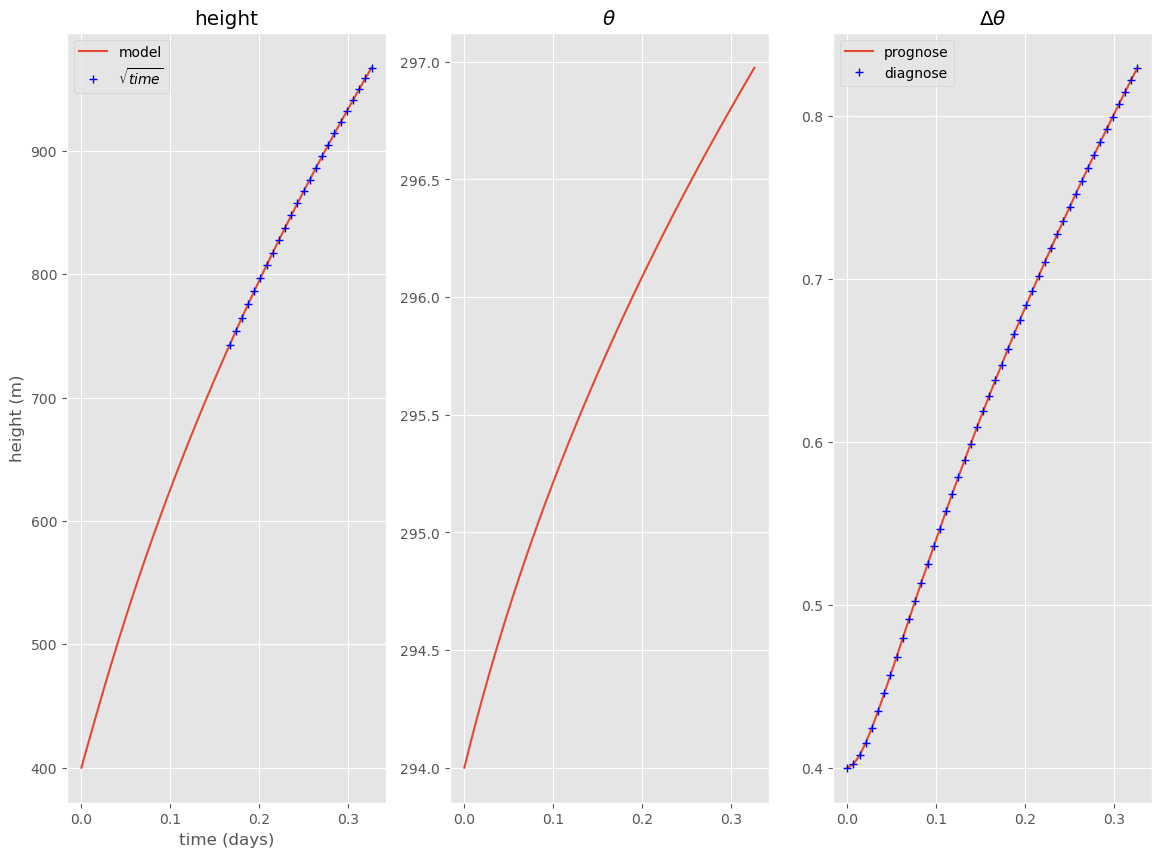

In [2]:
gamma=6.e-3  #K/m
theta_sst = 290.
intercept = 292.
h=400.
theta=294.
theta_ft = intercept + gamma*h
del_theta=theta_ft - theta
dtout=10.  #minutes
tf=8   #hours
dtout=dtout*60.
tf=tf*3600.
tspan = np.arange(0.,tf,dtout)
vars_init=[theta,h,del_theta]  #theta (K), height (m), del theta (K) to start

F0 = 60 #W/m^2
wh= 0.  #m/s
output=integrate.odeint(dmixed_vars_old, vars_init, tspan,(F0,wh,gamma))
old_result=pd.DataFrame.from_records(output,columns=['theta','h','deltheta'])
old_result['time']=tspan/3600./24.  #days
old_result['diag_jump'] = (intercept + gamma*old_result['h']) - old_result['theta']

plt.style.use('ggplot')
fig,ax = plt.subplots(1,3,figsize=(14,10))
out=ax[0].plot(old_result['time'],old_result['h'],label='model')
ax[0].set(ylabel='height (m)',xlabel='time (days)',title='height')
#
# overlay sqrt(time) line for last half of timeseries
# passing through the midpoint
#

full_time=old_result['time'].values
midpoint=int(len(full_time)/2.)
#
# start time at zero
#
the_time_zeroed=full_time[midpoint:] - full_time[midpoint]
the_height=old_result['h'].values[midpoint:]
h0=the_height[0]
hend=the_height[-1]
slope=(hend**2. - h0**2.)/the_time_zeroed[-1]
hsquared= h0**2. + slope*the_time_zeroed
#
# move time back to last half of timeseries
#
the_time_analytic = full_time[midpoint] + the_time_zeroed
the_h=np.sqrt(hsquared)
ax[0].plot(the_time_analytic,the_h,'b+',label='$\sqrt{time}$')
ax[0].legend(loc='best')

out=ax[1].plot(old_result['time'],old_result['theta'])
ax[1].set(title=r'$\theta$')
out=ax[2].plot(old_result['time'],old_result['deltheta'],label='prognose')
ax[2].set(title=r'$\Delta \theta$')
out=ax[2].plot(old_result['time'],old_result['diag_jump'],'b+',label='diagnose')
out=ax[2].legend(loc='best')

### Now go to diagnostic jump and compare with old_result

In [3]:
import numpy as np
import scipy.integrate as integrate
from matplotlib import pyplot as plt
import pandas as pd

#
# only two variables 
#

def dmixed_vars(the_vars,tstep):
    """
      the_vars[0]= thetabar
      the_vars[1] = h
      
      constant flux F0. no subsidence, diagnosed deltheta
    """
    gamma = 6.e-3
    k=0.2
    theta_sst = 290.
    intercept = 292.
    theta_ft = intercept + the_vars[1]*gamma
    deltheta = theta_ft - the_vars[0]
    F0 = 60./1004.
    Fint = -k*F0
    went = -Fint/deltheta
    rho=1.
    cp=1004.
    derivs=np.empty_like(the_vars)
    derivs[0]=(F0 - Fint)/(the_vars[1]*rho)
    derivs[1] = went
    return derivs

In [4]:
dtout=10.  #minutes
tf=24   #hours
dtout=dtout*60.
tf=tf*3600.
tspan = np.arange(0.,tf,dtout)
vars_init=[294.,400.]  #theta (K), height (m) to start
output=integrate.odeint(dmixed_vars, vars_init, tspan)
result=pd.DataFrame.from_records(output,columns=['theta','h'])
result['time']=tspan/3600./24.  #hours

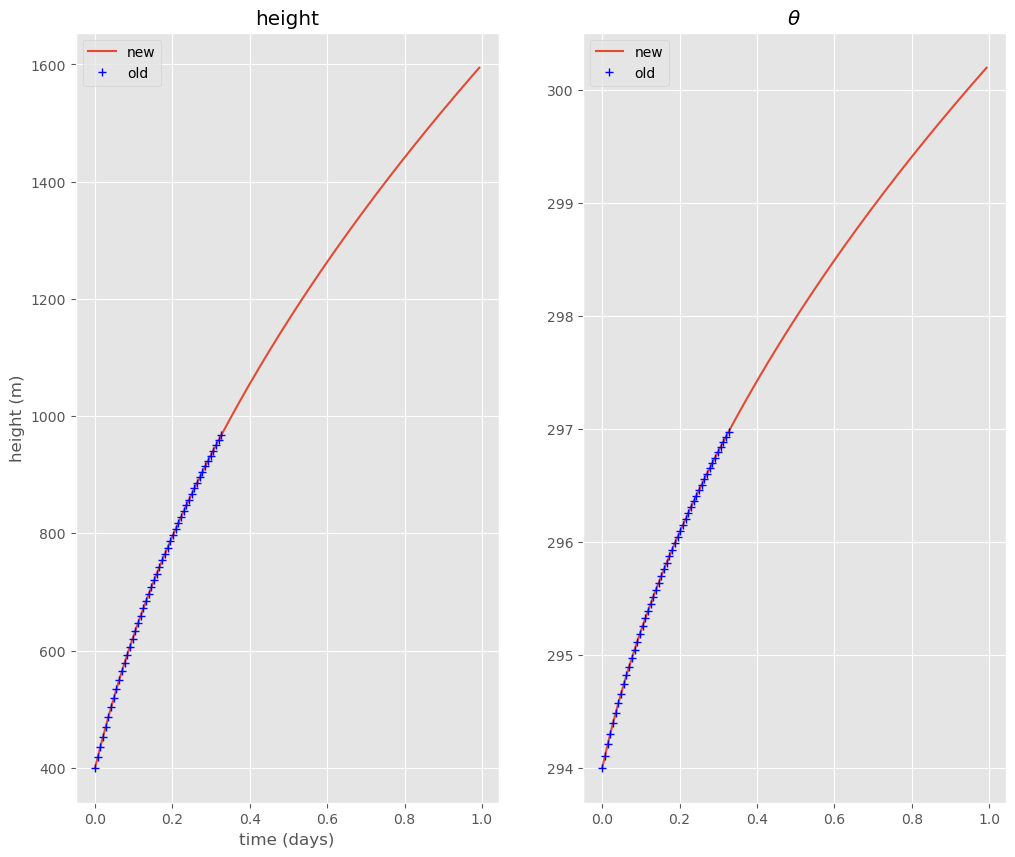

In [5]:
plt.close('all')
plt.style.use('ggplot')
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].plot(result['time'],result['h'],label='new')
ax[0].plot(old_result['time'],old_result['h'],'b+',label='old')
ax[0].set(ylabel='height (m)',xlabel='time (days)',title='height')
ax[0].legend(loc='best')
ax[1].plot(result['time'],result['theta'],label='new')
ax[1].plot(old_result['time'],old_result['theta'],'b+',label='old')
ax[1].set(title=r'$\theta$')
out=ax[1].legend(loc='best')

## Summary

Predicting $\Delta \theta$ is overkill for a dry mixed layer, but
we'll see that when we add clouds things get more complicated